In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


In [3]:
data = []
labels = []
classes = 43
dataset_dir = 'C:\SAIF\Deep Learning'
#Retrieving the images and their labels 
metaDf = pd.read_csv("C:\SAIF\Deep Learning\Meta.csv") 
trainDf = pd.read_csv("C:\SAIF\Deep Learning\Train.csv") 
testDf= pd.read_csv("C:\SAIF\Deep Learning\Test.csv") 
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']
print('SHAPE of training set:',trainDf.shape)
print('SHAPE of test set:',trainDf.shape)
print('SHAPE of MetaInfo:',trainDf.shape)


SHAPE of training set: (39209, 8)
SHAPE of test set: (39209, 8)
SHAPE of MetaInfo: (39209, 8)


In [4]:
trainDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), trainDf['Path']))
testDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), testDf['Path']))
metaDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), metaDf['Path']))


In [5]:
trainDf.sample(10)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
24730,35,38,5,5,30,33,17,C:\SAIF\Deep Learning\train/17/00017_00009_000...
15456,33,34,5,6,28,29,10,C:\SAIF\Deep Learning\train/10/00010_00014_000...
2295,40,39,6,5,35,34,1,C:\SAIF\Deep Learning\train/1/00001_00057_0001...
12206,70,68,6,6,64,62,8,C:\SAIF\Deep Learning\train/8/00008_00001_0002...
22875,47,55,6,6,42,50,14,C:\SAIF\Deep Learning\train/14/00014_00008_000...
12837,72,70,7,6,66,64,8,C:\SAIF\Deep Learning\train/8/00008_00022_0002...
9595,54,56,6,5,49,51,5,C:\SAIF\Deep Learning\train/5/00005_00038_0002...
27500,52,46,6,5,47,41,22,C:\SAIF\Deep Learning\train/22/00022_00006_000...
16609,49,49,5,5,44,44,10,C:\SAIF\Deep Learning\train/10/00010_00052_000...
38703,44,45,6,6,38,40,40,C:\SAIF\Deep Learning\train/40/00040_00011_000...


In [6]:
metaDf.sample(10)


,Path,ClassId,ShapeId,ColorId,SignId
17,C:\SAIF\Deep Learning\meta/23.png,23,0,0,1.13
31,C:\SAIF\Deep Learning\meta/37.png,37,1,1,4.5
12,C:\SAIF\Deep Learning\meta/19.png,19,0,0,1.2
29,C:\SAIF\Deep Learning\meta/35.png,35,1,1,4.1
22,C:\SAIF\Deep Learning\meta/29.png,29,0,0,1.34
0,C:\SAIF\Deep Learning\meta/27.png,27,0,0,1.32
5,C:\SAIF\Deep Learning\meta/12.png,12,2,2,2.3
24,C:\SAIF\Deep Learning\meta/30.png,30,0,0,NaN
9,C:\SAIF\Deep Learning\meta/16.png,16,1,0,3.3
1,C:\SAIF\Deep Learning\meta/0.png,0,1,0,3.29


C:\Users\saleh\AppData\Local\Temp\ipykernel_13372\3953170065.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.ax_joint.legend()


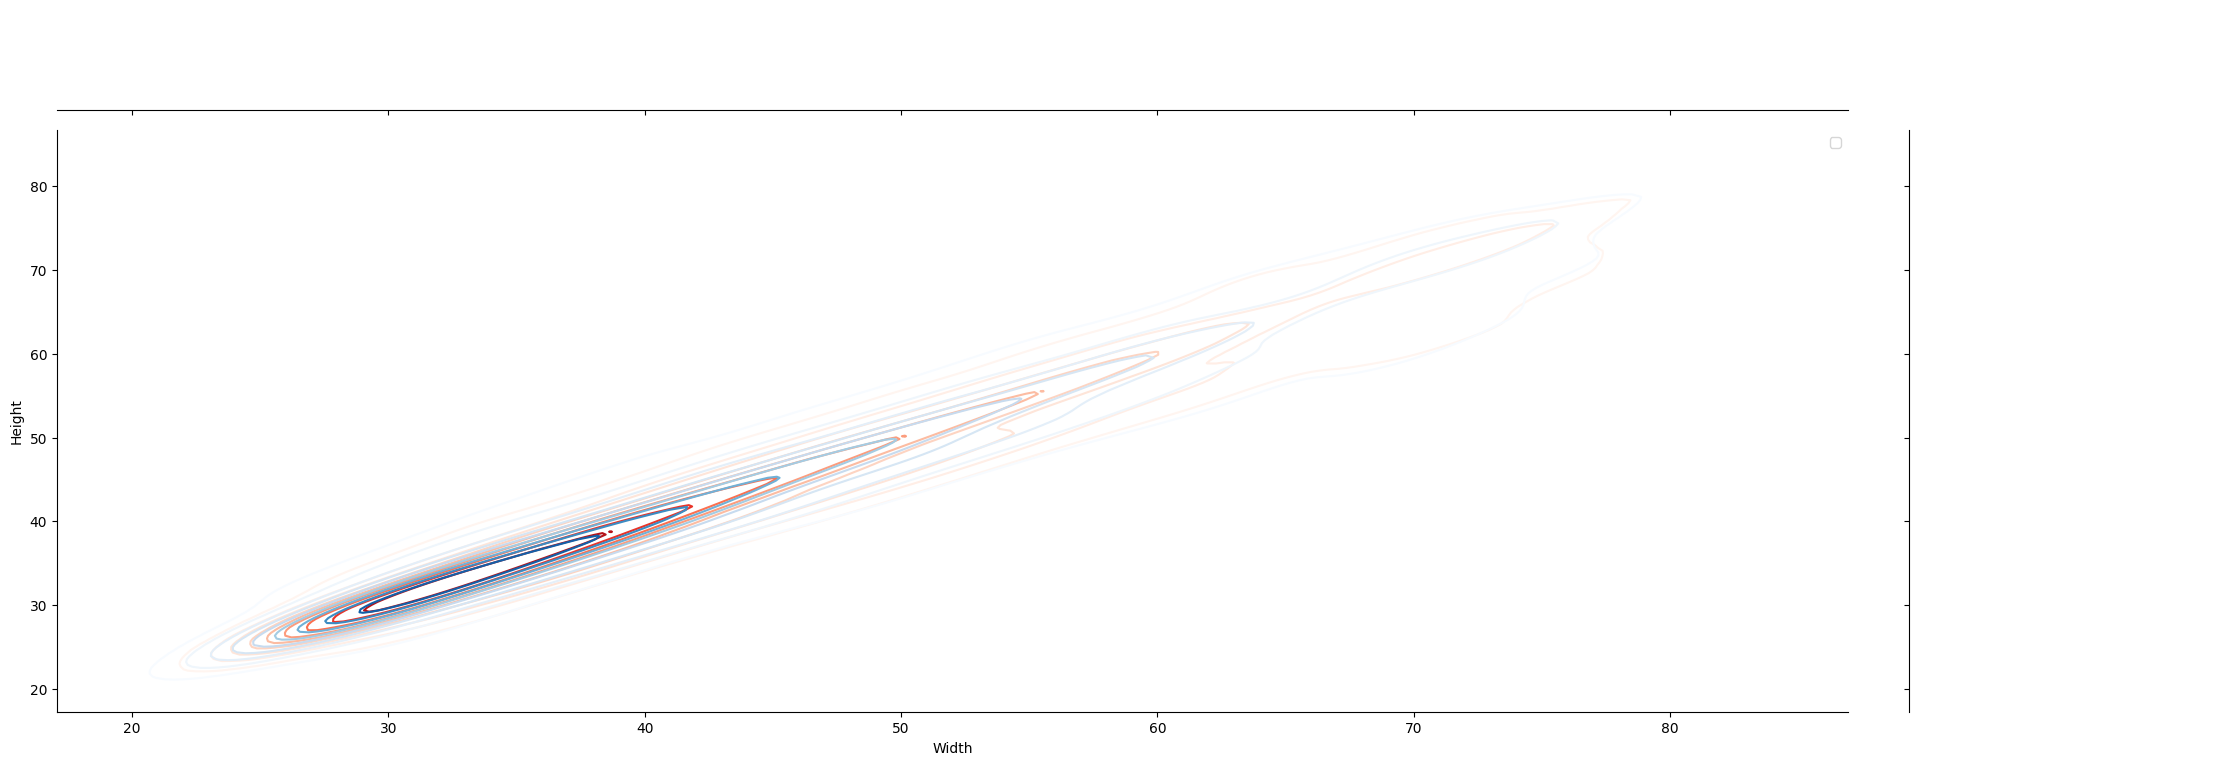

In [9]:
# Subset based on Width and Height thresholds
trainDfDpiSubset = trainDf[(trainDf.Width < 80) & (trainDf.Height < 80)]
testDfDpiSubset = testDf[(testDf.Width < 80) & (testDf.Height < 80)]

# Create JointGrid
g = sns.JointGrid(x="Width", y="Height", data=trainDfDpiSubset)

# Plot KDE contours on the joint axes
sns.kdeplot(
    x=trainDfDpiSubset["Width"], y=trainDfDpiSubset["Height"],
    ax=g.ax_joint, cmap="Reds", fill=False, levels=10, label="Train"
)
sns.kdeplot(
    x=testDfDpiSubset["Width"], y=testDfDpiSubset["Height"],
    ax=g.ax_joint, cmap="Blues", fill=False, levels=10, label="Test"
)

# Adjust figure size
g.fig.set_figwidth(25)
g.fig.set_figheight(8)

# Add legend manually
g.ax_joint.legend()

# Show plot
plt.show()


### Target Class

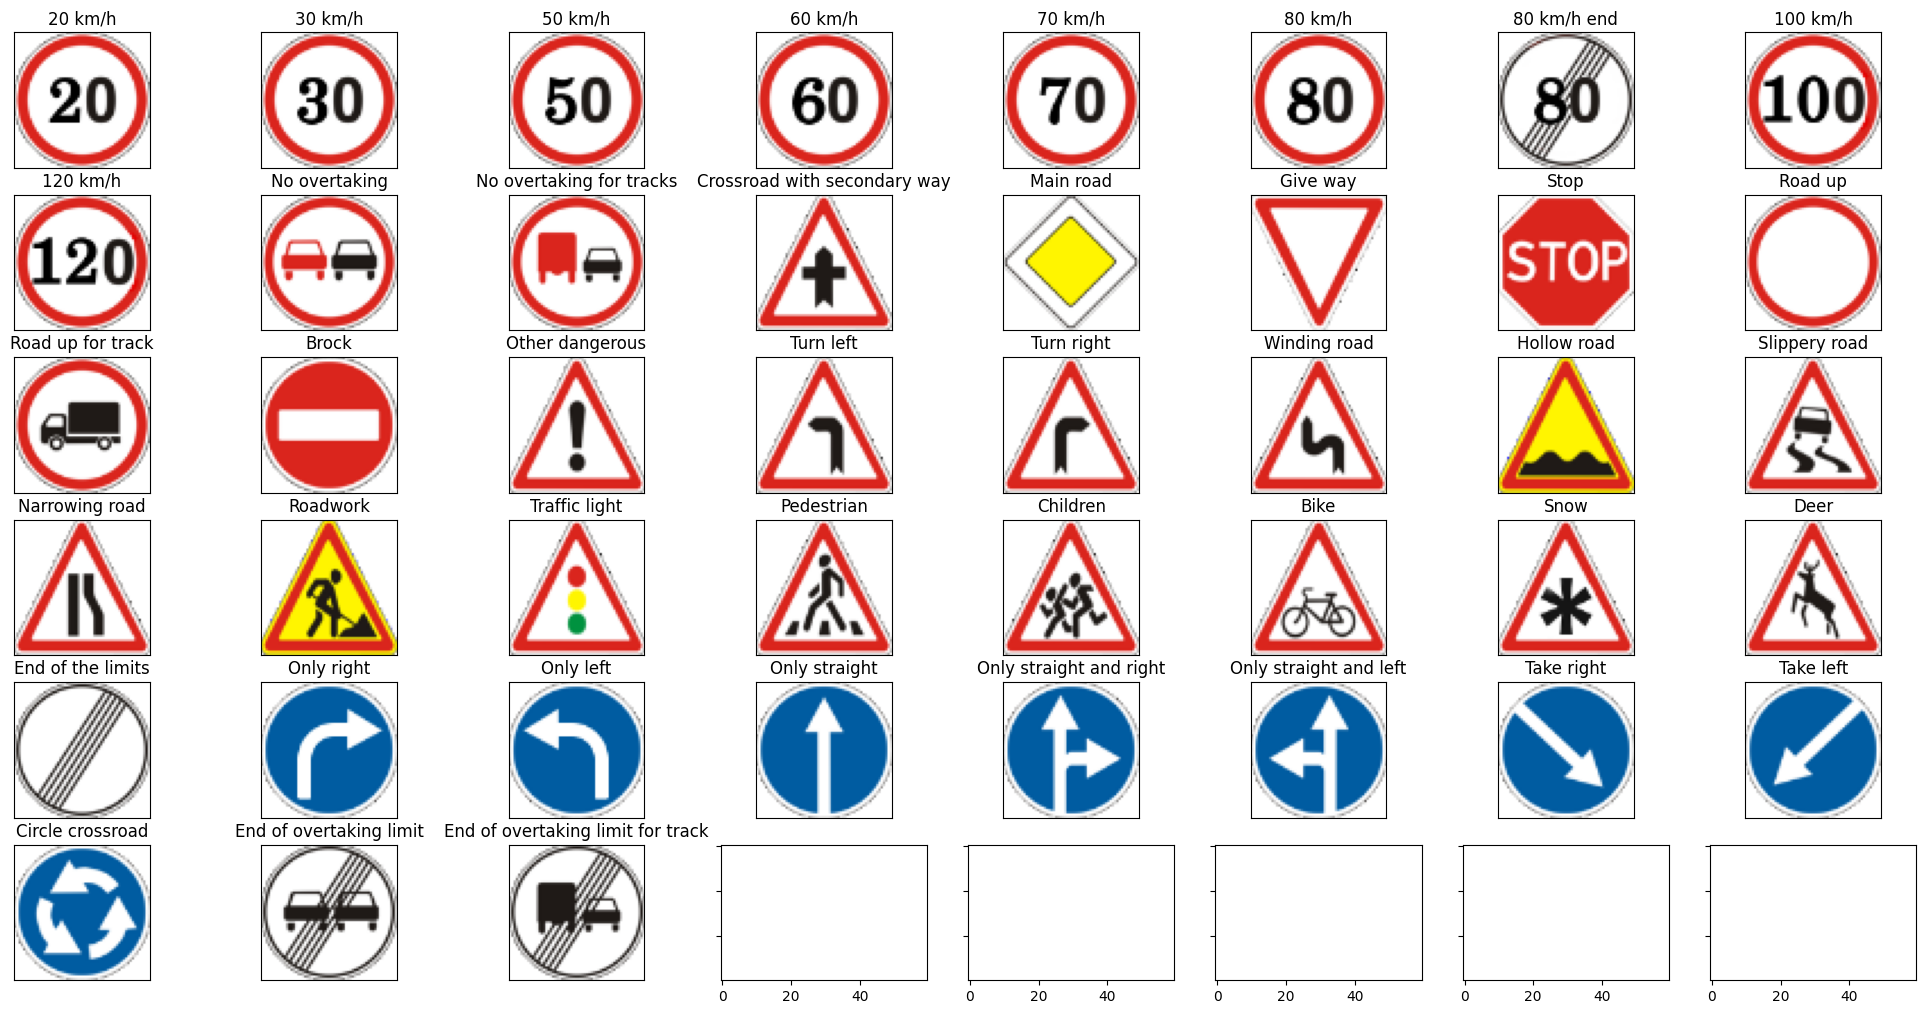

In [10]:
sns.set_style()
rows = 6
cols = 8
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
metaDf = metaDf.sort_values(by=['ClassId'])
idx = 0
for i in range(rows):
    for j in range(cols):
        if idx > 42:
            break
            
        img = cv2.imread(metaDf["Path"].tolist()[idx], cv2.IMREAD_UNCHANGED)
        img[np.where(img[:,:,3]==0)] = [255,255,255,255]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        
        axs[i,j].imshow(img)
        axs[i,j].set_facecolor('xkcd:salmon')
        axs[i,j].set_facecolor((1.0, 0.47, 0.42))
        axs[i,j].set_title(labels[int(metaDf["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1


### Training Class

C:/Users/meenakshi.h/Documents/Traffic_sign_Recognition/


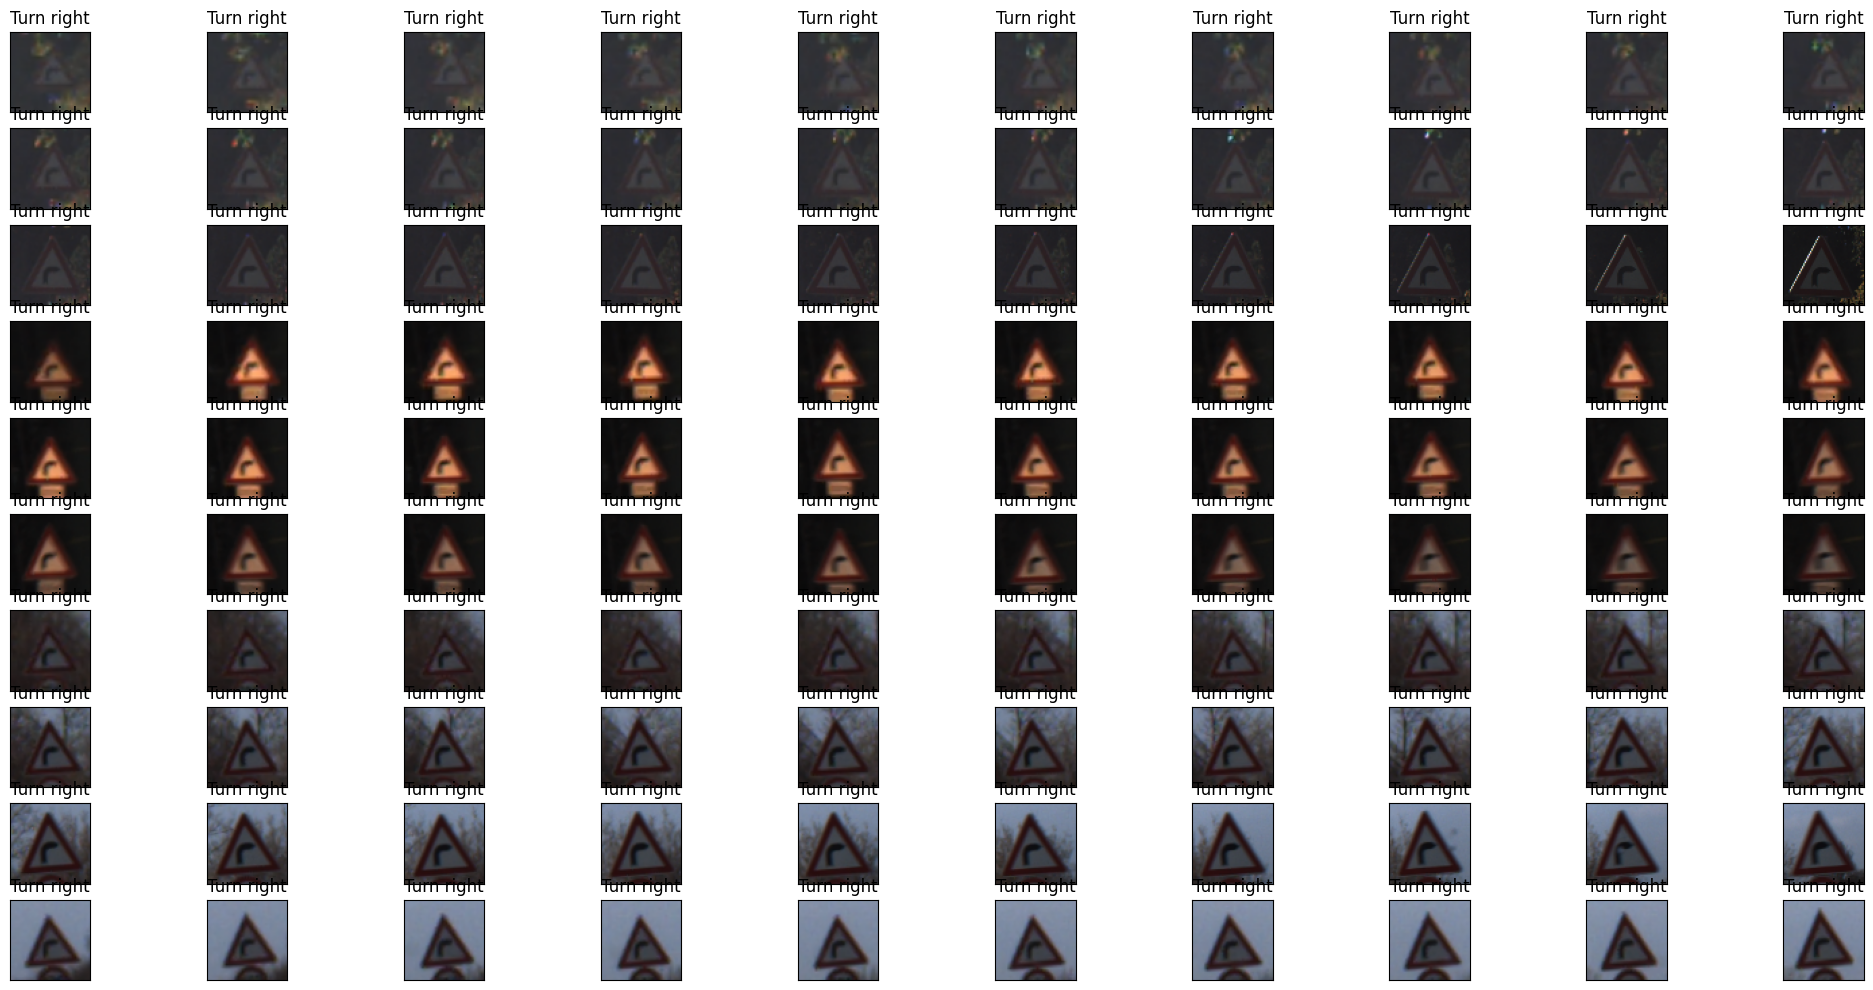

In [11]:
rows = 10
cols = 10
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
cur_path = 'C:/Users/meenakshi.h/Documents/Traffic_sign_Recognition/'
print(cur_path)
idx = 0
for i in range(rows):
    for j in range(cols):
        path = os.path.join(cur_path,trainDf["Path"].tolist()[idx]) 
        img = cv2.imread(path,cv2.IMREAD_UNCHANGED)
        #print(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        axs[i,j].imshow(img)
        axs[i,j].set_title(labels[int(trainDf["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1


### Model building using Convolutional Neural Network

#### Step 2 :  Extract the path for training, testing and label images

In [21]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()
print(cur_path)
#Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(cur_path, 'Traffic_sign_Recognition', 'Train', str(i))

    images = os.listdir(path)
    print(path)
    print(images)
    #Converting lists into numpy arrays
    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")


c:\SAIF\Deep Learning
c:\SAIF\Deep Learning\Traffic_sign_Recognition\Train\0
['00000_00000_00000.png', '00000_00000_00001.png', '00000_00000_00002.png', '00000_00000_00003.png', '00000_00000_00004.png', '00000_00000_00005.png', '00000_00000_00006.png', '00000_00000_00007.png', '00000_00000_00008.png', '00000_00000_00009.png', '00000_00000_00010.png', '00000_00000_00011.png', '00000_00000_00012.png', '00000_00000_00013.png', '00000_00000_00014.png', '00000_00000_00015.png', '00000_00000_00016.png', '00000_00000_00017.png', '00000_00000_00018.png', '00000_00000_00019.png', '00000_00000_00020.png', '00000_00000_00021.png', '00000_00000_00022.png', '00000_00000_00023.png', '00000_00000_00024.png', '00000_00000_00025.png', '00000_00000_00026.png', '00000_00000_00027.png', '00000_00000_00028.png', '00000_00000_00029.png', '00000_00001_00000.png', '00000_00001_00001.png', '00000_00001_00002.png', '00000_00001_00003.png', '00000_00001_00004.png', '00000_00001_00005.png', '00000_00001_00006.png

#### Step3: Read the images and convert to numpy arrays


In [22]:
#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)


(39209, 30, 30, 3) (39209,)


#### Step4: Split the training set


In [23]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


#### Step5: Convert the label using one hot encoding 


In [24]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)


#### Step6: Build the CNN model


In [25]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))


#### Step7: Compile the model


In [26]:
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.3039 - loss: 3.3573 - val_accuracy: 0.8542 - val_loss: 0.5946
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.7318 - loss: 0.9132 - val_accuracy: 0.9231 - val_loss: 0.2796
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.8256 - loss: 0.5962 - val_accuracy: 0.9439 - val_loss: 0.2017
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.8634 - loss: 0.4636 - val_accuracy: 0.9588 - val_loss: 0.1476
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.8804 - loss: 0.4165 - val_accuracy: 0.9555 - val_loss: 0.1509
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.8916 - loss: 0.3646 - val_accuracy: 0.9751 - val_loss: 0.1004
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.9053 - loss: 0.3310 - val_accuracy: 0.9742 - val_loss: 0.0941
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.9060 - loss: 0.3198 - 

#### Step8: Plot the accuracy and loss


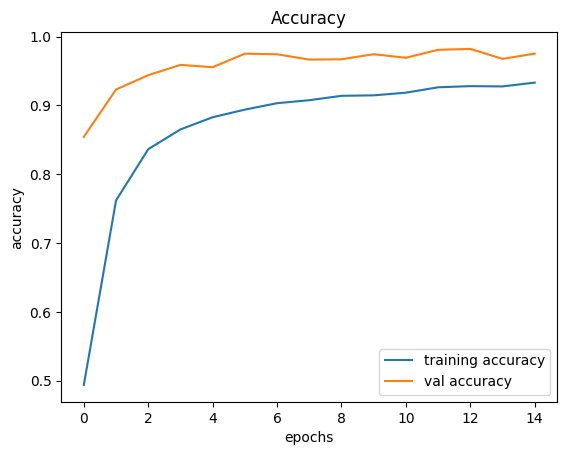

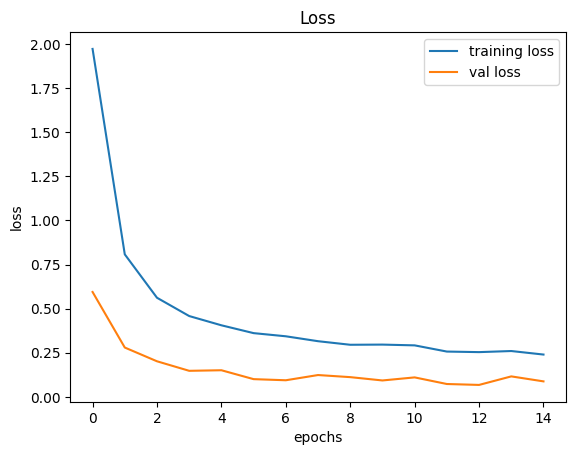

In [27]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


#### Step9: Load the test data along with labels

In [29]:
#testing accuracy on test dataset
cur_path = os.getcwd()
print(cur_path)
#Retrieving the images and their labels 
#for i in range(classes):
path = os.path.join(cur_path,'Traffic_sign_Recognition\\Test')
images = os.listdir(path)
print(path)
print(images)


c:\SAIF\Deep Learning
c:\SAIF\Deep Learning\Traffic_sign_Recognition\Test
['00000.png', '00001.png', '00002.png', '00003.png', '00004.png', '00005.png', '00006.png', '00007.png', '00008.png', '00009.png', '00010.png', '00011.png', '00012.png', '00013.png', '00014.png', '00015.png', '00016.png', '00017.png', '00018.png', '00019.png', '00020.png', '00021.png', '00022.png', '00023.png', '00024.png', '00025.png', '00026.png', '00027.png', '00028.png', '00029.png', '00030.png', '00031.png', '00032.png', '00033.png', '00034.png', '00035.png', '00036.png', '00037.png', '00038.png', '00039.png', '00040.png', '00041.png', '00042.png', '00043.png', '00044.png', '00045.png', '00046.png', '00047.png', '00048.png', '00049.png', '00050.png', '00051.png', '00052.png', '00053.png', '00054.png', '00055.png', '00056.png', '00057.png', '00058.png', '00059.png', '00060.png', '00061.png', '00062.png', '00063.png', '00064.png', '00065.png', '00066.png', '00067.png', '00068.png', '00069.png', '00070.png', '0

#### Step10: Predict the class

In [32]:
X_test = np.array(data)
pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

from sklearn.metrics import accuracy_score
true_labels = np.array(labels)
print("Accuracy:", accuracy_score(true_labels, pred))


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step
Accuracy: 0.981866408222602
